## TODO
rename file folders -- done 
check if differenet image count per class is problem -- done
load the dataset -- done
resize images via PIL Image load > convert to torch tensor or directly loading it via torchvision read image -- done
pridat vahovanie pre triedy ktorych je menej poctov - teda lepsia stratova funkcia
!!!  este pre vizualizaciu, confusion matrix - spravne je na diagonale  -- done 


# Imports


In [1]:
import sys
import hashlib
!{sys.executable} -m pip install torch torchvision matplotlib numpy 
from collections import Counter
import shutil

import torch
#for faster training
torch.backends.cudnn.benchmark = True
import numpy as np
#to load the dataset and to split the dataset
from torch.utils.data import DataLoader, Subset, random_split
#for resizing of images
from torchvision import transforms


from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import wandb

from torchvision.datasets import ImageFolder
from PIL import Image
from pathlib import Path
import os
import matplotlib.pyplot as plt
import random


use_wandb = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Device: cuda


In [2]:
#simply getting working directory and appending the archive directories to it
base_dir = os.getcwd()
dataset_dir = os.path.join(base_dir, "archive/raw-img")
print("Dataset directory: ", dataset_dir)

Dataset directory:  c:\Users\adamg\Desktop\Ulohy\3 vyska\ZNEUS\cvika\zadania\zadanie 2\archive/raw-img


In [3]:
#size of the image that will be after "normalization" (setting all the images to the same size)
img_size = (224, 224)
#transormation that will be used on every image https://docs.pytorch.org/vision/stable/transforms.html
image_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor()
    ])
analysis_transform = transforms.ToTensor()

#loading the dataset with pytorch using ImageFolder https://docs.pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html

image_dataset = ImageFolder(
    root = dataset_dir, 
    transform = image_transform 
)



#if you see ragno, my translate_names.py is not working correctly xd (its spider)
print("Dataset classes: ", image_dataset.classes)

#splitting the dataset to 70% train, 10% validation and 20% train using random_split   https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.random_split

dataset_size = len(image_dataset)
print("Dataset Size:\t", dataset_size)
train_size = int(0.7 * dataset_size)
validation_size   = int(0.1 * dataset_size)
test_size  = dataset_size - train_size - validation_size

train_dataset, validation_dataset, test_dataset = random_split(image_dataset, [train_size, validation_size, test_size])
print("Split sizes:\nTrain:\t\t", len(train_dataset), "\nValidation:\t", len(validation_dataset), "\nTest:\t\t", len(test_dataset))


Dataset classes:  ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']
Dataset Size:	 26179
Split sizes:
Train:		 18325 
Validation:	 2617 
Test:		 5237


In [4]:
#loading the image_dataset to dataLoader https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
train_loader = DataLoader(
    dataset = train_dataset,
    shuffle = True, #this shuffles order of images each epoch, random_split randomizes it only once, maybe we dont need this
    batch_size = 10  #1 is default, maybe experiment with this later
)
validation_loader = DataLoader(
    dataset = validation_dataset,
    shuffle = True,
    batch_size = 10  
)
test_loader = DataLoader(
    dataset = test_dataset,
    shuffle = True,
    batch_size = 10  
)

#this is how we can iterate through the DataLoader
for image_tensor, labels in train_loader:
    #shape is [Batch_size, Channels, Height, Width]
    print(image_tensor.shape)
    #and label (correct class of the image) for each image in tensor (images)
    print(labels) 
    break

torch.Size([10, 3, 224, 224])
tensor([7, 8, 4, 8, 8, 2, 5, 2, 3, 8])


In [5]:
translate = {
    "cane": "dog",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "butterfly",
    "gallina": "chicken",
    "gatto": "cat",
    "mucca": "cow",
    "pecora": "sheep",
    "scoiattolo": "squirrel",
    "ragno": "spider",
}


def rename_dirs(base_path: str):
    for fn in os.listdir(base_path):
        full = os.path.join(base_path, fn)

        if not os.path.isdir(full):
            continue
        if fn not in translate:
            continue

        new_name = translate[fn]
        print(f"{fn}  ->  {new_name}")
        os.rename(full, os.path.join(base_path, new_name))


def show_sample_images(dataset, num_images=10):
    indices = random.sample(range(len(dataset)), num_images)

    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(indices):
        img, label = dataset[idx] 
        if hasattr(img, "permute"):
            img = img.permute(1, 2, 0).numpy()

        plt.subplot(2, (num_images + 1) // 2, i + 1)
        plt.imshow(img)
        plt.title(dataset.classes[label])
        plt.axis("off")

    plt.tight_layout()
    plt.show()

Classes: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']
Classes Count: 10

Images per class:
butterfly: 2112
cat: 1668
chicken: 3098
cow: 1866
dog: 4863
elephant: 1446
horse: 2623
sheep: 1820
spider: 4821
squirrel: 1862


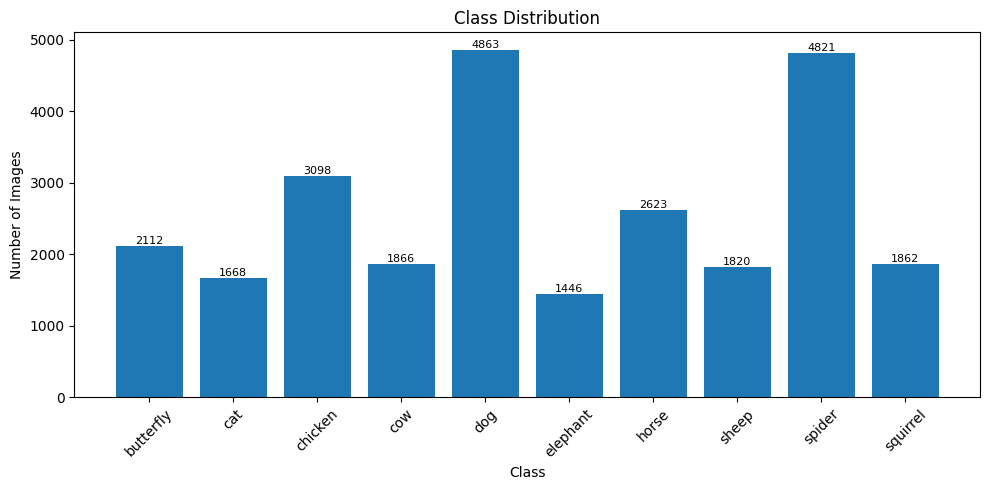

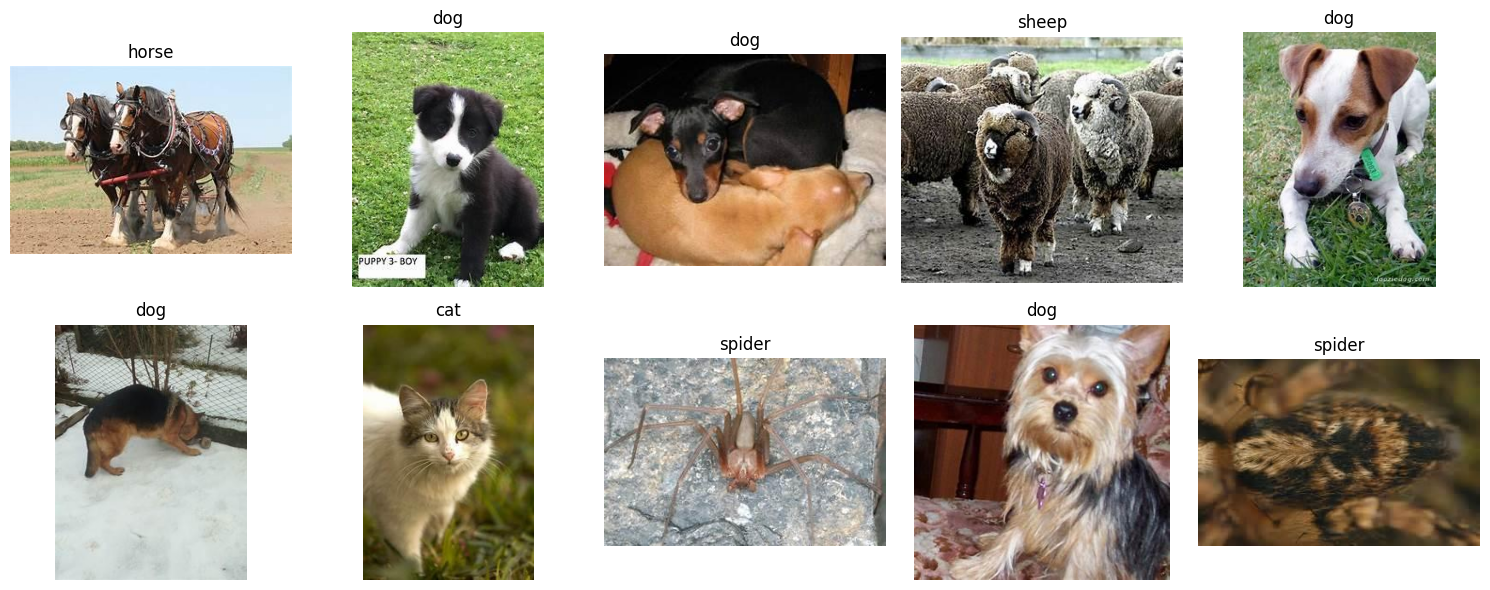

Images size statistics:
Mean width:  320.04
Mean height: 252.63
Min width:   60,  Max width:   6720
Min height:  57, Max height:  6000


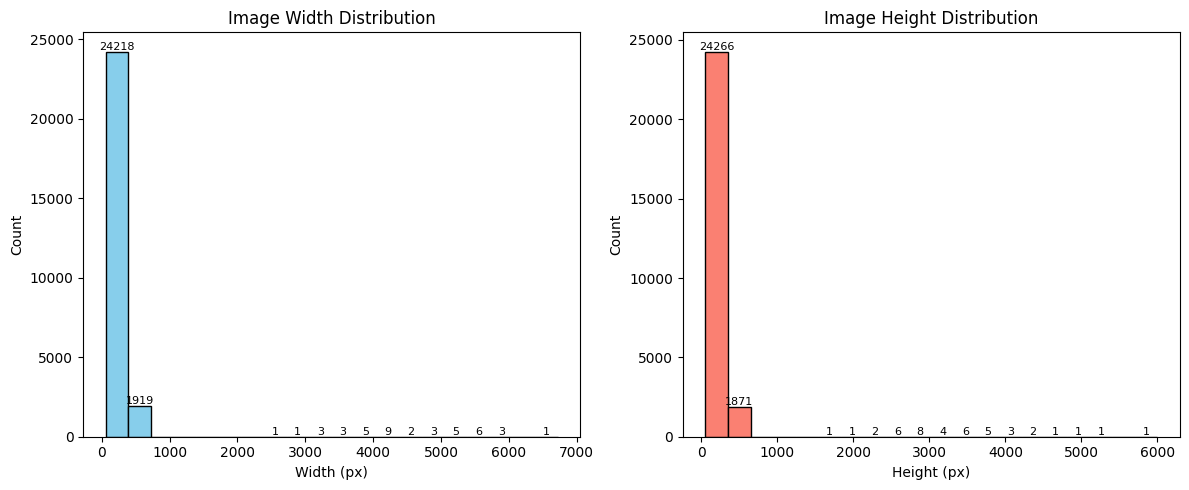

Smallest Image:
Size: 60x57
Path: c:\Users\adamg\Desktop\Ulohy\3 vyska\ZNEUS\cvika\zadania\zadanie 2\archive/raw-img\horse\OIP-4UmK-NKWl1fwEK9GfBSGKAAAAA.jpeg

Largest Image:
Size: 6720x4480
Path: c:\Users\adamg\Desktop\Ulohy\3 vyska\ZNEUS\cvika\zadania\zadanie 2\archive/raw-img\cat\max-boettinger-486490-unsplash.jpg


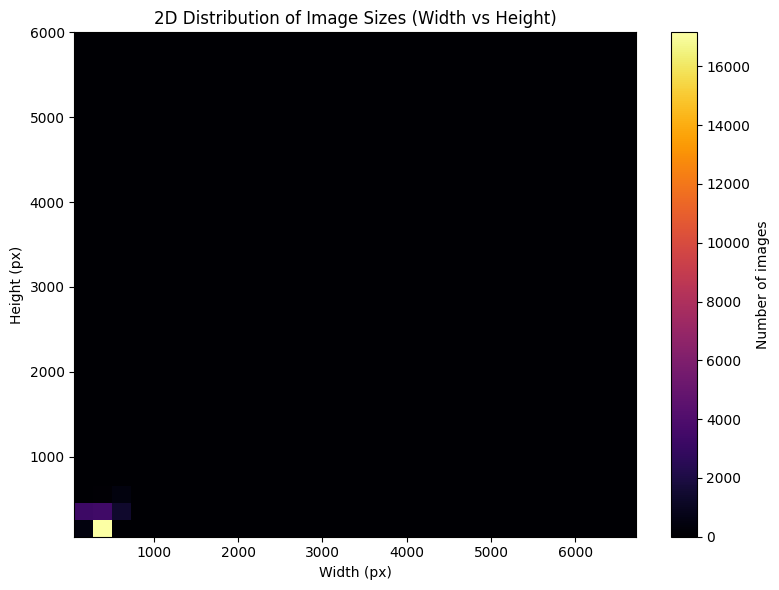

In [6]:
# data anylisis here >
# loading dataset for data vizualization and analysis
rename_dirs(dataset_dir)

analysis_dataset = ImageFolder(root=dataset_dir, transform=analysis_transform)
analysis_loader = DataLoader(dataset=analysis_dataset, shuffle=True, batch_size=10)

print("Classes:", analysis_dataset.classes)
print("Classes Count:", len(analysis_dataset.classes))

counts = Counter([label for _, label in analysis_dataset.samples])

print("\nImages per class:")
for idx, cls_name in enumerate(analysis_dataset.classes):
    print(f"{cls_name}: {counts[idx]}")

plt.figure(figsize=(10, 5))
values = [counts[i] for i in range(len(analysis_dataset.classes))]
bars = plt.bar(analysis_dataset.classes, values)
plt.xticks(rotation=45)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution")

for bar, value in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        value,
        str(int(value)),
        ha="center",
        va="bottom",
        fontsize=8,
    )

plt.tight_layout()
plt.show()

show_sample_images(analysis_dataset, num_images=10)


paths = [path for (path, _) in analysis_dataset.samples]

widths = []
heights = []

for p in paths:
    with Image.open(p) as img:
        w, h = img.size
        widths.append(w)
        heights.append(h)

widths = np.array(widths)
heights = np.array(heights)

print("Images size statistics:")
print(f"Mean width:  {widths.mean():.2f}")
print(f"Mean height: {heights.mean():.2f}")
print(f"Min width:   {widths.min()},  Max width:   {widths.max()}")
print(f"Min height:  {heights.min()}, Max height:  {heights.max()}")

plt.figure(figsize=(12, 5))

# Width distribution histogram
plt.subplot(1, 2, 1)
counts_w, bins_w, patches_w = plt.hist(
    widths, bins=20, color="skyblue", edgecolor="black"
)
plt.title("Image Width Distribution")
plt.xlabel("Width (px)")
plt.ylabel("Count")

# Titles above bars
for count, patch in zip(counts_w, patches_w):
    if count > 0:
        plt.text(
            patch.get_x() + patch.get_width() / 2,
            count,
            str(int(count)),
            ha="center",
            va="bottom",
            fontsize=8,
        )

# Height distribution histogram
plt.subplot(1, 2, 2)
counts_h, bins_h, patches_h = plt.hist(
    heights, bins=20, color="salmon", edgecolor="black"
)
plt.title("Image Height Distribution")
plt.xlabel("Height (px)")
plt.ylabel("Count")

for count, patch in zip(counts_h, patches_h):
    if count > 0:
        plt.text(
            patch.get_x() + patch.get_width() / 2,
            count,
            str(int(count)),
            ha="center",
            va="bottom",
            fontsize=8,
        )

plt.tight_layout()
plt.show()


sizes = []

for path, _ in analysis_dataset.samples:
    with Image.open(path) as img:
        w, h = img.size
        sizes.append((w, h, path))


min_size = min(sizes, key=lambda x: x[0] * x[1])
max_size = max(sizes, key=lambda x: x[0] * x[1])

print("Smallest Image:")
print(f"Size: {min_size[0]}x{min_size[1]}")
print(f"Path: {min_size[2]}")
print()

print("Largest Image:")
print(f"Size: {max_size[0]}x{max_size[1]}")
print(f"Path: {max_size[2]}")

plt.figure(figsize=(8, 6))

plt.hist2d(widths, heights, bins=30, cmap="inferno")
plt.colorbar(label="Number of images")

plt.title("2D Distribution of Image Sizes (Width vs Height)")
plt.xlabel("Width (px)")
plt.ylabel("Height (px)")

plt.tight_layout()
plt.show()

In [7]:
# Split dataset into train, val, test folders
random.seed(42)

raw_dir = dataset_dir
base_dir = os.path.dirname(raw_dir)

train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

for d in [train_dir, val_dir, test_dir]:
    os.makedirs(d, exist_ok=True)

train_ratio = 0.70
val_ratio = 0.10
test_ratio = 0.20

valid_ext = (".jpg", ".jpeg", ".png", ".bmp")

for cls_name in os.listdir(raw_dir):
    cls_path = os.path.join(raw_dir, cls_name)
    if not os.path.isdir(cls_path):
        continue

    files = [f for f in os.listdir(cls_path) if f.lower().endswith(valid_ext)]

    if not files:
        continue

    random.shuffle(files)

    n = len(files)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)
    n_test = n - n_train - n_val

    train_files = files[:n_train]
    val_files = files[n_train : n_train + n_val]
    test_files = files[n_train + n_val :]

    train_cls_dir = os.path.join(train_dir, cls_name)
    val_cls_dir = os.path.join(val_dir, cls_name)
    test_cls_dir = os.path.join(test_dir, cls_name)

    os.makedirs(train_cls_dir, exist_ok=True)
    os.makedirs(val_cls_dir, exist_ok=True)
    os.makedirs(test_cls_dir, exist_ok=True)

    for fname in train_files:
        shutil.copy2(os.path.join(cls_path, fname), os.path.join(train_cls_dir, fname))

    for fname in val_files:
        shutil.copy2(os.path.join(cls_path, fname), os.path.join(val_cls_dir, fname))

    for fname in test_files:
        shutil.copy2(os.path.join(cls_path, fname), os.path.join(test_cls_dir, fname))

    print(f"{cls_name}: {n_train} train | {n_val} val | {n_test} test")

print("\nNew split complete:")
print("Train:", train_dir)
print("Val:  ", val_dir)
print("Test: ", test_dir)

butterfly: 1478 train | 211 val | 423 test
cat: 1167 train | 166 val | 335 test
chicken: 2168 train | 309 val | 621 test
cow: 1306 train | 186 val | 374 test
dog: 3404 train | 486 val | 973 test
elephant: 1012 train | 144 val | 290 test
horse: 1836 train | 262 val | 525 test
sheep: 1274 train | 182 val | 364 test
spider: 3374 train | 482 val | 965 test
squirrel: 1303 train | 186 val | 373 test

New split complete:
Train: c:\Users\adamg\Desktop\Ulohy\3 vyska\ZNEUS\cvika\zadania\zadanie 2\archive\train
Val:   c:\Users\adamg\Desktop\Ulohy\3 vyska\ZNEUS\cvika\zadania\zadanie 2\archive\val
Test:  c:\Users\adamg\Desktop\Ulohy\3 vyska\ZNEUS\cvika\zadania\zadanie 2\archive\test


In [8]:

train_path = os.path.join(base_dir, "train")
val_path = os.path.join(base_dir, "val")
test_path = os.path.join(base_dir, "test")

preprocess_basic = transforms.Compose(
    [transforms.Resize((224, 224)), transforms.ToTensor()]
)

train_raw = ImageFolder(train_path, transform=preprocess_basic)

train_raw_loader = DataLoader(dataset=train_raw, batch_size=512, shuffle=False, num_workers=4, pin_memory=True)

pixel_sum = torch.zeros(3).to(device)
pixel_sq_sum = torch.zeros(3).to(device)
total_pixels = 0

for batch_images, _ in train_raw_loader:
    batch_images = batch_images.to(device)
    batch_size, channels, height, width = batch_images.shape
    num_pixels = batch_size * height * width
    total_pixels += num_pixels

    pixel_sum += batch_images.sum(dim=[0, 2, 3])
    pixel_sq_sum += (batch_images**2).sum(dim=[0, 2, 3])

mean = pixel_sum / total_pixels
std = torch.sqrt(pixel_sq_sum / total_pixels - mean**2)

print("Train Normalization Stats:")
print("Mean:", mean.tolist())
print("Std: ", std.tolist())

img_size = (112,122)

train_transforms = transforms.Compose(
    [
        transforms.Resize(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

train_set = ImageFolder(train_path, transform=train_transforms)
val_set = ImageFolder(val_path, transform=val_transforms)
test_set = ImageFolder(test_path, transform=test_transforms)


train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

print("\nData Preparation finished!")
print("Train samples:", len(train_set))
print("Val samples:  ", len(val_set))
print("Test samples: ", len(test_set))

#adding subsets for testing, later delete them
# train_subset = Subset(train_set, range(500))
# val_subset = Subset(val_set, range(500))
# test_subset = Subset(val_set, range(500))

# train_sub_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
# val_sub_loader = DataLoader(val_subset, batch_size=16, shuffle=False)
# test_sub_loader = DataLoader(test_subset, batch_size=16, shuffle=False)
# print(len(train_set), len(train_sub_loader))

Train Normalization Stats:
Mean: [0.5180419683456421, 0.5006217956542969, 0.4129711389541626]
Std:  [0.26520174741744995, 0.2605193853378296, 0.2776200771331787]

Data Preparation finished!
Train samples: 18322
Val samples:   2614
Test samples:  5243


In [ ]:
#Convolutional Model   
#Using pytorch convolutional layers https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d
#MaxPooling is used in the presentation in the VGG Net, lets use it as well https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html

#since we have multiclass classification, we will use softmax at the output  https://docs.pytorch.org/docs/stable/generated/torch.nn.Softmax.html 
class AnimalMLP(torch.nn.Module):
    def __init__(self, hidden_layers, kernel_size, stride, device):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.layers = torch.nn.ModuleList()
        self.prev = 3
        self.padding = 1
        self.device = device
        self.FCL_layers = torch.nn.ModuleList()
        self.FCL_out_channels = hidden_layers[2]
        self.softmax = torch.nn.Softmax(dim=1)

        
        
        for out_channels in hidden_layers[0]:
            #adding flat padding = 1
            self.layers.append(torch.nn.Conv2d(self.prev, out_channels, self.kernel_size, self.stride, self.padding))
            self.layers.append(torch.nn.ReLU())
            self.layers.append(torch.nn.Conv2d(out_channels, out_channels, self.kernel_size, self.stride, self.padding))
            self.layers.append(torch.nn.ReLU())
            self.layers.append(torch.nn.MaxPool2d(2))
            
            self.prev = out_channels
            
        for out_channels in hidden_layers[1]:
            self.layers.append(torch.nn.Conv2d(self.prev, out_channels, self.kernel_size, self.stride, self.padding))
            self.layers.append(torch.nn.ReLU())
            self.layers.append(torch.nn.Conv2d(out_channels, out_channels, self.kernel_size, self.stride, self.padding))
            self.layers.append(torch.nn.ReLU())
            self.layers.append(torch.nn.Conv2d(out_channels, out_channels, self.kernel_size, self.stride, self.padding))
            self.layers.append(torch.nn.ReLU())
            self.layers.append(torch.nn.MaxPool2d(2))
            #using this to set all layers to gpu
            self.prev = out_channels
            
        self.to(self.device)

    def prepare_FCL_layers(self, input_size):
        if len(self.FCL_layers) > 0:
            return
        #added 3 Fully Connected Layers and at the end add Softmax
        self.FCL_layers.append(torch.nn.Flatten())
        self.FCL_layers.append(torch.nn.Linear(input_size, self.FCL_out_channels[0]))
        self.FCL_layers.append(torch.nn.ReLU())
        self.FCL_layers.append(torch.nn.Linear(self.FCL_out_channels[0], self.FCL_out_channels[1]))
        self.FCL_layers.append(torch.nn.ReLU())
        self.FCL_layers.append(torch.nn.Linear(self.FCL_out_channels[1], self.FCL_out_channels[2]))
        # self.FCL_layers.append(torch.nn.Softmax(dim=1))  #since we will use CrossEntropyLoss, which includes softmax, we dont need to add it here
        #using this to set all layers to gpu
        self.to(self.device)
    
    def forward(self, input):
        #going through convolutional layers
        for layer in self.layers:
            input = layer(input)
        #since output of our convolution is: torch.Size([10, 512, 7, 7]) 
        #input for our FCL will be 512*7*7 = 25088
        ## Preparing the FCL layers with the correct input size
        self.prepare_FCL_layers(input.shape[1]*input.shape[2]*input.shape[3])
        #going through fully connected layers
        for layer in self.FCL_layers:
            input = layer(input)
        return input
    

        

def train_model(model, data_loader, optimizer, loss_function):
    # print("train loss: ")
    model.train()
    for image_tensor, labels in data_loader:
        #shape is [Batch_size, Channels, Height, Width]
        #send data to gpu
        image_tensor = image_tensor.to(device)
        labels = labels.to(device)
        
        #reset gradients, do forward pass, compute loss, do backward pass and optimize
        optimizer.zero_grad()
        output = model.forward(image_tensor)
        loss = loss_function(output, labels)
        # print(loss.item(), end=" ")
        loss.backward()
        optimizer.step()
        
        # print("FCL output:", output.shape, model.softmax_for_print(output))

        # break

#since we dont want our model to be trained on this part of dataset, we dont calculate gradients, nor use optimizer, just use loss function to determine how good the model is on unseen data
def validate_model(model, data_loader, loss_function):
    model.eval()   #to set the model to evaluation mode

    correct_predictions = 0
    
    all_losses, all_probs, all_labels = [], [], []
    
    #torch.no_grad() to disable gradient computing
    with torch.no_grad():
        for image_tensor, labels in data_loader:
            image_tensor = image_tensor.to(device)
            labels = labels.to(device)
            
            output = model.forward(image_tensor)
            loss = loss_function(output, labels)
            # print("\nvalidation loss: ", loss.item())
            # total_loss += loss.item() #accumulating loss for each 
            
            predicted_classes = output.argmax(dim=1) #pick only the predicted classes of batch size
            correct_predictions += (predicted_classes == labels).sum().item()  # this compares the predicted and real classes, counts how many are correct and itemizes it to a number
            # print("correct prediction:", correct_predictions)

            
            all_losses.append(loss.item())
            all_labels.append(labels)
            all_probs.append(model.softmax(output))
        
        all_labels = torch.cat(all_labels).cpu().numpy()   #pass labels to cpu
        all_probs = torch.cat(all_probs).cpu().numpy()
        all_predicted_classes = all_probs.argmax(axis=1)
        
        f1 = f1_score(all_labels, all_predicted_classes, average='macro')
        accuracy = (all_predicted_classes == all_labels).mean()
        average_loss = sum(all_losses) / len(all_losses)

        
        print("average loss: ", average_loss, "acurracy: ", accuracy, "F1 score:", f1)
    validation_output = {
        "av_loss": average_loss, 
        "acc": accuracy,
        "f1": f1,
        "labels": all_labels,
        "classes": all_predicted_classes
    }
    return validation_output
        
            

In [ ]:
min_number_of_epochs = 30
# config = [
#     {"hidden_layers" : [[64, 128], [256, 512, 512], [4096, 4096, len(test_set.classes)]],
#      "learning_rate" : 0.0001
#      },
#     {"hidden_layers" : [[64, 128], [256, 512, 512], [4096, 4096, len(test_set.classes)]],
#      "learning_rate" : 0.00001
#      },
#     {"hidden_layers" : [[64, 128], [256, 512, 512], [4096, 4096, len(test_set.classes)]],
#      "learning_rate" : 0.001
#      },
# ]
hidden_layers = [[64, 128], [256, 256, 256], [1024, 1024, len(test_set.classes)]] #this is kinda static, if this changes, output of convolution changes, so the expected input of FCL will change 
learning_rate = 0.0001
best_model_f1 = -torch.inf
best_model_path = "best_model.pt"
#defining our model
model = AnimalMLP(hidden_layers, 3, 1, device)
# for currenct_config in configs:
if use_wandb:
    wandb_run = wandb.init(project="animal10")  #, config=current_config
    wandb_run.watch(model, log="all")
#defining loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


#Training
for epoch in range(min_number_of_epochs):
    print("\nEpoch: ", epoch+1)
    #we want, every epoch to train our model on train dataset and right after check validation dataset
    train_model(model, train_loader, optimizer, loss_function)
    validation_output = validate_model(model, val_loader, loss_function)
    if use_wandb:
        wandb_run.log(validation_output)
    #saving best model   https://docs.pytorch.org/docs/stable/notes/serialization.html#recommend-saving-models
    if validation_output["f1"] > best_model_f1:
        best_model_f1 = validation_output["f1"]
        torch.save(model.state_dict(), best_model_path)
    
if use_wandb:
    wandb_run.finish()



wandb: Currently logged in as: adamglog9919 (adamglog9919-my_org_ig) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



Epoch:  1
average loss:  2.298893201918829 acurracy:  0.18553940321346596 F1 score: 0.03132063287051986

Epoch:  2
average loss:  2.0766507443927584 acurracy:  0.2616679418515685 F1 score: 0.15064104223204877

Epoch:  3
average loss:  1.9148253145672025 acurracy:  0.31484315225707726 F1 score: 0.18911925078928243

Epoch:  4
average loss:  1.8150539454959689 acurracy:  0.35998469778117825 F1 score: 0.26862719430524484

Epoch:  5
average loss:  1.7247554319245475 acurracy:  0.39824024483550113 F1 score: 0.3076298806187102

Epoch:  6
average loss:  1.620227881840297 acurracy:  0.436495791889824 F1 score: 0.3610666756602851

Epoch:  7
average loss:  1.5517443532035464 acurracy:  0.4640397857689365 F1 score: 0.3969585486550367

Epoch:  8
average loss:  1.4442701197805858 acurracy:  0.49273144605967867 F1 score: 0.4234022254806916

Epoch:  9
average loss:  1.3685168396858942 acurracy:  0.5263963274674828 F1 score: 0.45464329780016416

Epoch:  10
average loss:  1.4024070614860171 acurracy:  

acc,▁▂▃▃▄▅▅▅▆▆▆▇▇▇▇▇▇▇██▇█████████
av_loss,█▇▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▂
f1,▁▂▃▄▄▅▅▅▆▆▆▇▇▇▇▇▇███▇█████████
acc,0.66947
av_loss,1.08875
f1,0.64002


In [11]:
#load the best model
model.load_state_dict(torch.load(best_model_path))


#Testing
testing_output = validate_model(model, test_loader, loss_function)

average loss:  1.0228060520276792 acurracy:  0.6671752813274843 F1 score: 0.6406077401037404


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


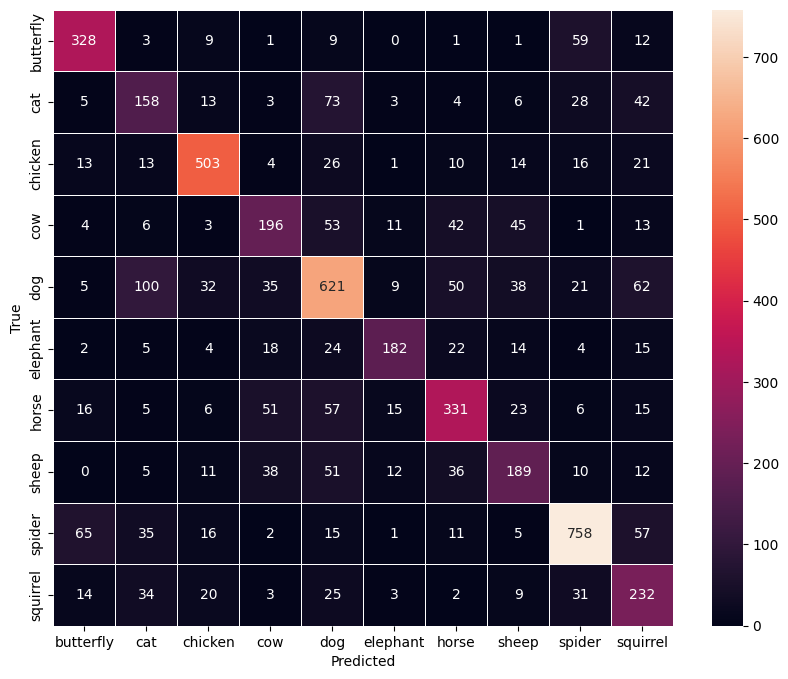

In [12]:
#log confusion matrix of best model https://wandb.ai/wandb/plots/reports/Confusion-Matrix-Usage-and-Examples--VmlldzozMDg1NTM

if use_wandb: 
    wandb_run = wandb.init(project="animal10", reinit=True, name=f"best_model_{random.randint(1,100)}")
    wandb_run.log({"conf_mat": wandb.plot.confusion_matrix(y_true=testing_output["labels"], preds=testing_output["classes"], class_names=test_set.classes)})
    wandb_run.finish()
    
    
plt.figure(figsize=(10,8))
confusion_mat = confusion_matrix(testing_output["labels"], testing_output["classes"], labels=list(range(len(test_set.classes)))) 
sns.heatmap(confusion_mat, annot=True, xticklabels=test_set.classes, yticklabels=test_set.classes, fmt="d", linewidths=0.5)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()    